In [1]:
from All_functions_simulation_univariate import * 
from sklearn.linear_model import QuantileRegressor

In [2]:
################################### Data Generating ###################################

def myData(i, n=2200):
    """
    i: random seed
    n: number of samples
    """
    np.random.seed(i)
    X = np.random.uniform(-1, 1, n).reshape(-1, 1)
    Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)
    
    return X, Y

In [3]:
################################### Different Methods ###################################

def UTOPIA(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False"):
    """
    X,Y: input data
    alpha: coverage level
    """
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    # Obtain mean estimator
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")
    
    # Obtain quantile estimators
    quantile = [0.8,0.85,0.9,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)
    
    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
    E_t = E_t.T
    
    # solve optimization problem
    optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    
    # adjust interval
    alpha = 0.05
    delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)
    V_alpha_t = delta*V100_t
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth



def LQR(X,Y,alpha = 0.05,n_mean = 600,n_quantile = 600,n_test = 1000, known_mean = "False"):
    X_mean = X[0:n_mean,:]
    Y_mean = Y[0:n_mean,:]
    x_mean = X_mean[:,0]
    y_mean = Y_mean[:,0]

    X_quantile = X[n_mean:n_mean+n_quantile,:]
    Y_quantile = Y[n_mean:n_mean+n_quantile,:]

    X_test = X[n_mean+n_quantile:,:]
    Y_test = Y[n_mean+n_quantile:,:]

    # Estimate the mean
    if known_mean == "True":
        M_quantile = np.zeros(n_quantile).reshape(-1,1)
        M_test = np.zeros(n_test).reshape(-1,1)
    else:
        est_type = "NN2"
        M_quantile, M_test = mean_est_2(est_type,X_mean,Y_mean,X_quantile,X_test)
        
    # Estimate the quantile
    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)
    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    
    # Output bandwidth and coverage
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    
    return coverage, bandwidth


def SplitCF(X,Y,alpha = 0.05,n_mean = 600,n_res = 600,n_test = 1000, known_mean = "False"):
        X_mean = X[0:n_mean,:]
        Y_mean = Y[0:n_mean,:]
        x_mean = X_mean[:,0]
        y_mean = Y_mean[:,0]

        X_res = X[n_mean:n_mean+n_res,:]
        Y_res = Y[n_mean:n_mean+n_res,:]
        x_res = X_res[:,0]
        y_res = Y_res[:,0]

        X_test = X[n_mean+n_res:,:]
        Y_test = Y[n_mean+n_res:,:]
        x_test = X_test[:,0]
        y_test = Y_test[:,0]
        
        # Estimate the mean
        if known_mean == "True":
            y_res_pred = np.zeros(n_res)
            m_test = np.zeros(n_test)
            M_test = m_test.reshape(-1,1)
        else:
            est_type = "NN2"
            Y_res_pred, M_test = mean_est_2(est_type,X_mean,Y_mean,X_res,X_test)
            y_res_pred = Y_res_pred[:,0]
            
        # Calculate the conformity scores
        residuals = np.abs(y_res - y_res_pred)
        k = int((1 - alpha) * n_res)
        residuals_sorted = np.sort(residuals)
        threshold = residuals_sorted[k]
        
        # Calculate the prediction interval
        v_test = (threshold**2)*np.ones(n_test)
        V_test = v_test.reshape(-1,1)
        
        # Output bandwidth and coverage
        coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
        bandwidth = np.mean(V_test[:,0])
        
        return coverage, bandwidth
    

    
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value
    
def SDP(X,Y,alpha = 0.05,n_pre = 1000,n_opt = 100,n_adj = 100,n_t = 1000,known_mean = "False", sigma = 1):
    """
    Liang's method with Gaussian kernel
    sigma: parameter for the Gaussian kernel
    """
    
    X_pre = X[0:n_pre,:].reshape(-1, 1)
    Y_pre = Y[0:n_pre,:].reshape(-1, 1)

    X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
    Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

    X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
    Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


    X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
    
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN2"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
        
    K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
    output = sdpDual(K_opt, Y_opt-M_opt)
        
    K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
    shape_adj = K_adj @ output @ K_adj.T
    shape_adj = shape_adj.diagonal()
        
    K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
    shape_t = K_t @ output @ K_t.T
    shape_t = shape_t.diagonal()

    delta = -1
    Delta = 0
    prop = 0.5
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    while prop_outside > (0.75 * alpha) and delta != Delta:
        delta = prop * delta + (1 - prop) * Delta
        prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()


    V_alpha_t = (1 + delta) * shape_t
    V_alpha_t = V_alpha_t.reshape(-1,1)

    # Output bandwidth and coverage
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    
    return coverage, bandwidth






In [4]:
################################### Repeat Simulation ###################################

times = 200

UTOPIA_cover = np.zeros(times)
UTOPIA_wide = np.zeros(times)

LQR_cover = np.zeros(times)
LQR_wide = np.zeros(times)

SplitCF_cover = np.zeros(times)
SplitCF_wide = np.zeros(times)

SDP_cover = np.zeros(times)
SDP_wide = np.zeros(times)


for i in range(times):
    X,Y = myData(i)
    
    UTOPIA_cover[i], UTOPIA_wide[i] = UTOPIA(X,Y,known_mean = "False")
    LQR_cover[i], LQR_wide[i] = LQR(X,Y,known_mean = "False")
    SplitCF_cover[i], SplitCF_wide[i] = SplitCF(X,Y,known_mean = "False")
    SDP_cover[i], SDP_wide[i] = SDP(X,Y,known_mean = "False")
    
    

Output = np.vstack((UTOPIA_cover,UTOPIA_wide,LQR_cover,LQR_wide,SplitCF_cover,SplitCF_wide,SDP_cover,SDP_wide))
np.savetxt("repeat_S2.csv", Output, delimiter=",")


In [5]:
################################### Results ###################################

print("For UTOPIA:")
print("The mean of the coverage is", np.mean(UTOPIA_cover))
print("The median of the coverage is", np.median(UTOPIA_cover))
print("The SD of the coverage is", np.std(UTOPIA_cover))
print("The mean of the bandwidth is", np.mean(UTOPIA_wide))
print("The median of the bandwidth is", np.median(UTOPIA_wide))
print("The SD of the bandwidth is", np.std(UTOPIA_wide))


print("For LQR:")
print("The mean of the coverage is", np.mean(LQR_cover))
print("The median of the coverage is", np.median(LQR_cover))
print("The SD of the coverage is", np.std(LQR_cover))
print("The mean of the bandwidth is", np.mean(LQR_wide))
print("The median of the bandwidth is", np.median(LQR_wide))
print("The SD of the bandwidth is", np.std(LQR_wide))

print("For SplitCF:")
print("The mean of the coverage is", np.mean(SplitCF_cover))
print("The median of the coverage is", np.median(SplitCF_cover))
print("The SD of the coverage is", np.std(SplitCF_cover))
print("The mean of the bandwidth is", np.mean(SplitCF_wide))
print("The median of the bandwidth is", np.median(SplitCF_wide))
print("The SD of the bandwidth is", np.std(SplitCF_wide))

print("For SDP:")
print("The mean of the coverage is", np.mean(SDP_cover))
print("The median of the coverage is", np.median(SDP_cover))
print("The SD of the coverage is", np.std(SDP_cover))
print("The mean of the bandwidth is", np.mean(SDP_wide))
print("The median of the bandwidth is", np.median(SDP_wide))
print("The SD of the bandwidth is", np.std(SDP_wide))

For UTOPIA:
The mean of the coverage is 0.92048
The median of the coverage is 0.925
The SD of the coverage is 0.029307671350689044
The mean of the bandwidth is 4.855471567329823
The median of the bandwidth is 4.84663916590255
The SD of the bandwidth is 0.6141132149831228
For LQR:
The mean of the coverage is 0.9473599999999999
The median of the coverage is 0.9484999999999999
The SD of the coverage is 0.01698029446152213
The mean of the bandwidth is 10.025751635996373
The median of the bandwidth is 9.896551519752467
The SD of the bandwidth is 1.758910832538585
For SplitCF:
The mean of the coverage is 0.949905
The median of the coverage is 0.952
The SD of the coverage is 0.010692332533175333
The mean of the bandwidth is 9.91210953608209
The median of the bandwidth is 9.881024341366755
The SD of the bandwidth is 0.9176371572400266
For SDP:
The mean of the coverage is 0.9681049999999999
The median of the coverage is 0.97
The SD of the coverage is 0.014295243089923302
The mean of the bandwid

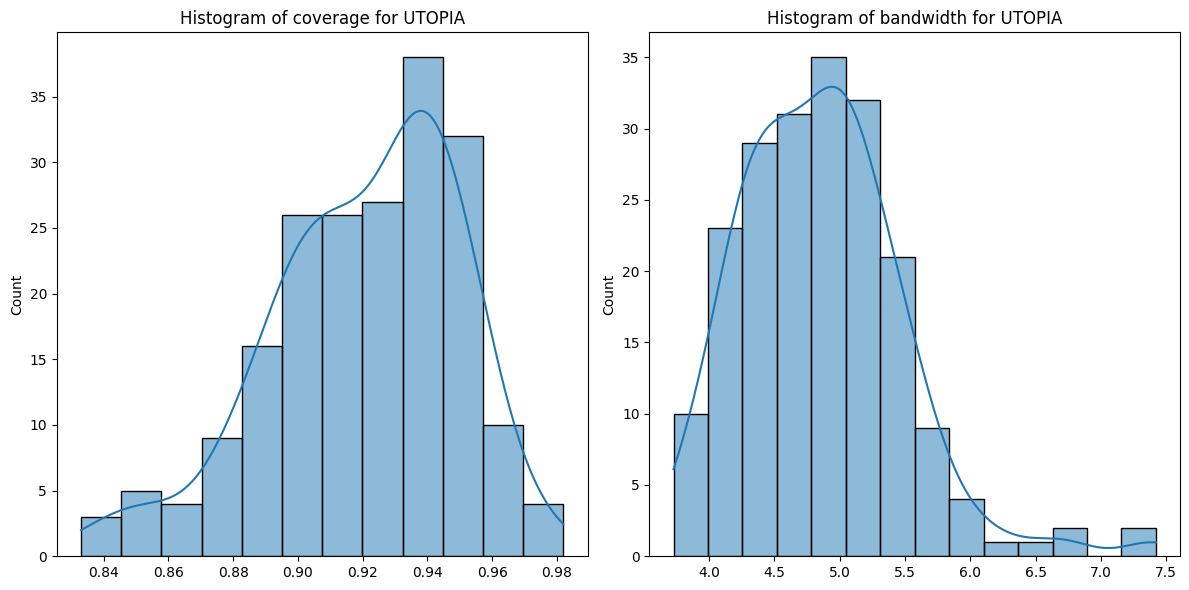

In [6]:
################################### Plots ###################################

fig, axes = plt.subplots(1, 2,figsize=(12, 6))
sns.histplot(UTOPIA_cover.reshape(-1, 1), kde = True,ax=axes[0],legend=False)
axes[0].set_title('Histogram of coverage for UTOPIA')
sns.histplot(UTOPIA_wide.reshape(-1, 1), kde = True,ax=axes[1],legend=False)
axes[1].set_title('Histogram of bandwidth for UTOPIA')
plt.tight_layout()
plt.show()

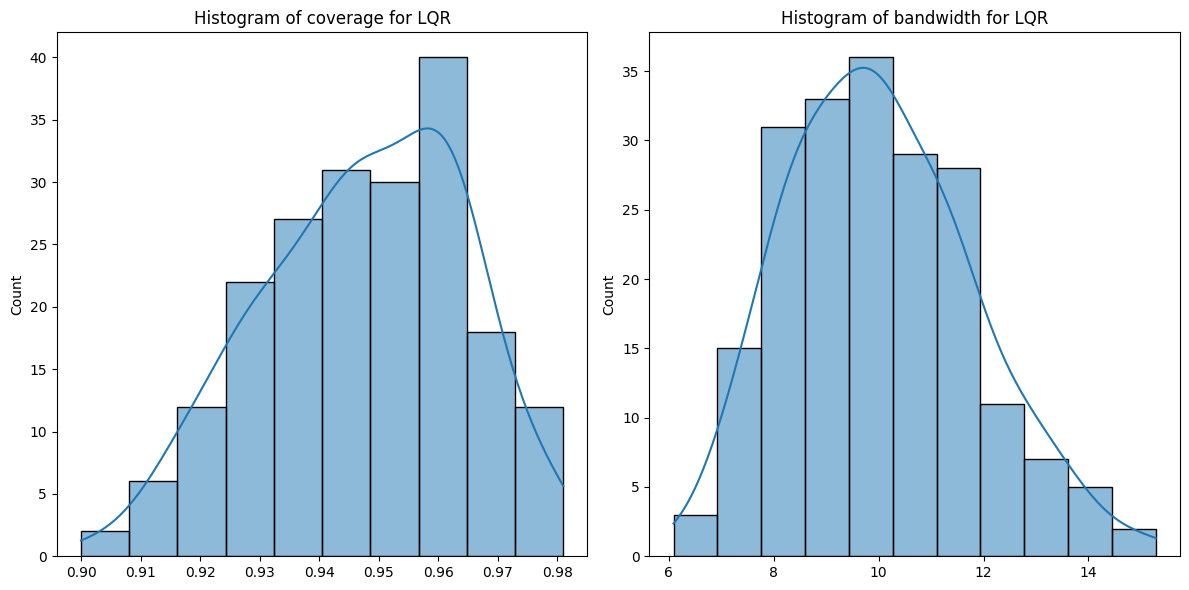

In [7]:
################################### Plots ###################################

fig, axes = plt.subplots(1, 2,figsize=(12, 6))
sns.histplot(LQR_cover.reshape(-1, 1), kde = True,ax=axes[0],legend=False)
axes[0].set_title('Histogram of coverage for LQR')
sns.histplot(LQR_wide.reshape(-1, 1), kde = True,ax=axes[1],legend=False)
axes[1].set_title('Histogram of bandwidth for LQR')
plt.tight_layout()
plt.show()

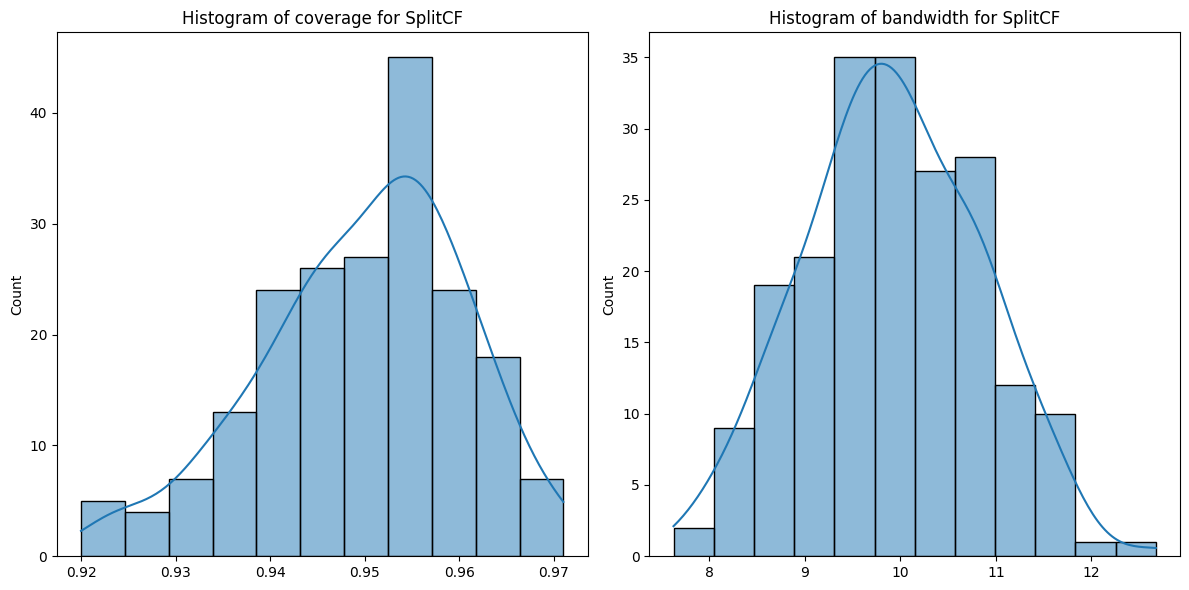

In [8]:
################################### Plots ###################################

fig, axes = plt.subplots(1, 2,figsize=(12, 6))
sns.histplot(SplitCF_cover.reshape(-1, 1), kde = True,ax=axes[0],legend=False)
axes[0].set_title('Histogram of coverage for SplitCF')
sns.histplot(SplitCF_wide.reshape(-1, 1), kde = True,ax=axes[1],legend=False)
axes[1].set_title('Histogram of bandwidth for SplitCF')
plt.tight_layout()
plt.show()

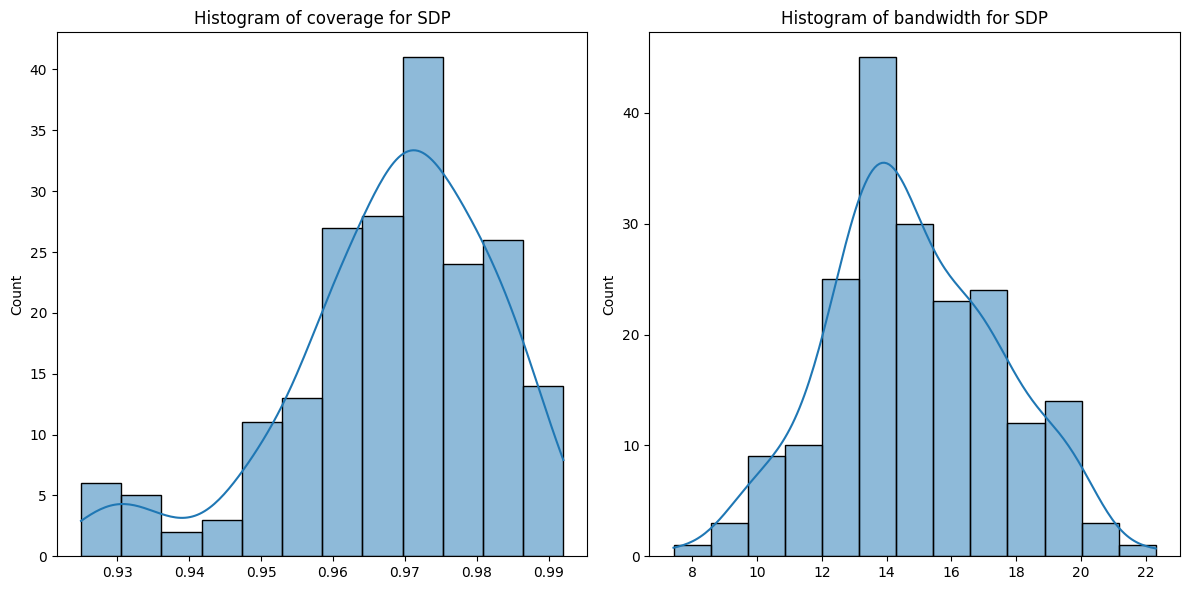

In [9]:
################################### Plots ###################################

fig, axes = plt.subplots(1, 2,figsize=(12, 6))
sns.histplot(SDP_cover.reshape(-1, 1), kde = True,ax=axes[0],legend=False)
axes[0].set_title('Histogram of coverage for SDP')
sns.histplot(SDP_wide.reshape(-1, 1), kde = True,ax=axes[1],legend=False)
axes[1].set_title('Histogram of bandwidth for SDP')
plt.tight_layout()
plt.show()